In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
import os
%matplotlib inline

In [2]:
import missingno as msno

In [3]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format',lambda x: '%.5f' % x)

# Dataset Description

This dataset was collected from the Cleveland Heart Disease Database and consists of 13 features for 270 patients as well as a labeled vector indicating whether specimen has heart disease or not. The 13 features (and their types) are listed and described below.

Features are described here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4441402/

Attribute Information: 
------------------------ 
1. age 
2. sex 
3. chest pain type (4 values) 
4. resting blood pressure 
5. serum cholestoral in mg/dl 
6. fasting blood sugar > 120 mg/dl 
7. resting electrocardiographic results (values 0,1,2) 
8. maximum heart rate achieved 
9. exercise induced angina 
10. oldpeak = ST depression induced by exercise relative to rest 
11. the slope of the peak exercise ST segment 
12. number of major vessels (0-3) colored by flourosopy 
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 

Attributes types 
----------------- 

* Real: 1,4,5,8,10,12 
* Ordered:11, 
* Binary: 2,6,9 
* Nominal:7,3,13 

In [4]:
CSV_PATH = os.path.join('data', 'heart_disease', 'train_values.csv')
X_train = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
X_train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.00000,1,45,170,0
ryoo3j,2,normal,110,3,0,0,0,214,1.60000,0,54,158,0
yt1s1x,1,normal,125,4,3,0,2,304,0.00000,1,77,162,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.00000,1,40,181,0
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.20000,1,59,145,0


In [5]:
CSV_PATH = os.path.join('data', 'heart_disease', 'test_values.csv')
X_test = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
X_test.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
olalu7,2,reversible_defect,170,1,0,0,2,288,0.20000,1,59,159,0
z9n6mx,1,normal,138,4,0,0,0,183,1.40000,0,35,182,0
5k4413,2,reversible_defect,120,4,0,0,2,177,2.50000,1,43,120,1
mrg7q5,1,normal,102,3,1,0,0,318,0.00000,0,60,160,0
uki4do,2,normal,138,4,1,0,2,166,3.60000,1,61,125,1


In [6]:
CSV_PATH = os.path.join('data', 'heart_disease', 'train_labels.csv')
y_train = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
y_train.head()

,heart_disease_present
patient_id,
0z64un,0
ryoo3j,0
yt1s1x,1
l2xjde,1
oyt4ek,0


**From the info printout below, we see that all of the features except for 'thal' (Thalium heart scan observation), which is has the object (string) type. From the given feature information, we know that the [sex, fasting_blood_sugar_gt_120_mg_per_dl, exercise_induced_angina] features are binary categories and [resting_ekg_results, chest_pain_type, thal, slope_of_peak_exercise_st_segment] categorical features with more than 2 categories.** 

**I'm using sklearn's machine learning libraries for my analysis, and sklearn is built on the numpy library which cannot correctly handle features of categorical data. To produce correct results, we'll have to make dummy variables for categorical features.**

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       180 non-null int64
thal                                    180 non-null object
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null int64
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null int64
resting_ekg_results                     180 non-null int64
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null int64
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 19.7+ KB


In [8]:
# converting the type of categorical features
X_train['chest_pain_type'] = X_train['chest_pain_type'].astype('category')
X_train['resting_ekg_results'] = X_train['resting_ekg_results'].astype('category')
X_train['thal'] = X_train['thal'].astype('category')
X_train['sex'] = X_train['sex'].astype('category')
X_train['fasting_blood_sugar_gt_120_mg_per_dl'] = X_train['fasting_blood_sugar_gt_120_mg_per_dl'].astype('category')
X_train['exercise_induced_angina'] = X_train['exercise_induced_angina'].astype('category')
X_train['slope_of_peak_exercise_st_segment'] = X_train['slope_of_peak_exercise_st_segment'].astype('category')

### Nominal Categorical Types

In [9]:
# 1: typical angina, 
# 2: atypical angina, 
# 3: non-angina, 
# 4: asymptotic angina
X_train['chest_pain_type'].unique()

[2, 3, 4, 1]
Categories (4, int64): [2, 3, 4, 1]

In [10]:
# Resting electrocardiographic results
# 0: normal, 
# 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 
# 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria;
X_train['resting_ekg_results'].unique()

[2, 0, 1]
Categories (3, int64): [2, 0, 1]

In [11]:
# Thalium heart scan
X_train['thal'].unique()

[normal, reversible_defect, fixed_defect]
Categories (3, object): [normal, reversible_defect, fixed_defect]

In [12]:
# 1: upsloping
# 2: flat
# 3: downsloping
X_train['slope_of_peak_exercise_st_segment'].unique()

[1, 2, 3]
Categories (3, int64): [1, 2, 3]

### Binary Categorical Types

In [13]:
# 0: Female, 1: Male
X_train['sex'].unique()

[1, 0]
Categories (2, int64): [1, 0]

In [14]:
# 0: False, 1: True
X_train['fasting_blood_sugar_gt_120_mg_per_dl'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [15]:
# 0: False, 1: True
X_train['exercise_induced_angina'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       180 non-null category
thal                                    180 non-null category
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null category
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null category
resting_ekg_results                     180 non-null category
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null category
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null category
dtypes: category(7), float64(1), int64(5)
memory usage: 11.8+ KB


**After changing the data types of the categorical features, we see that the memory usage dropped from 19.7 KB to 11.8 KB. While this is an extremely small dataset, on larger datasets this would produce a substantial improvement in runtime.**

## Exploratory Data Analysis
Before creating dummy variables (and increasing the number of features), we should examine the data.

In [18]:
# Joining the labeled output with the features, for plotting
train_df = y_train.join(X_train)

In [19]:
train_df.head()

,heart_disease_present,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,,
0z64un,0,1,normal,128,2,0,0,2,308,0.00000,1,45,170,0
ryoo3j,0,2,normal,110,3,0,0,0,214,1.60000,0,54,158,0
yt1s1x,1,1,normal,125,4,3,0,2,304,0.00000,1,77,162,1
l2xjde,1,1,reversible_defect,152,4,0,0,0,223,0.00000,1,40,181,0
oyt4ek,0,3,reversible_defect,178,1,0,0,2,270,4.20000,1,59,145,0


**As we'll be plotting some categorical features, I'll set an appropriate palette.**

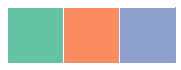

In [76]:
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
cat_palette = sns.color_palette(['#66c2a5', '#fc8d62', '#8da0cb'])
sns.palplot(cat_palette)

**From the frequency plot of heart disease below, we see that the two classes ('Heart Disease' and 'No Heart Disease') are approximately balanced, with 45% of observations having heart disease and the remaining population not having heart disease. **

(0, 105)

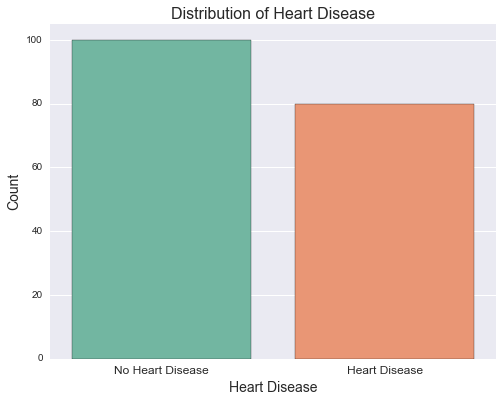

In [46]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=train_df, x='heart_disease_present', palette=cat_palette, ax=ax)
ax.set_title('Distribution of Heart Disease', fontsize=16)
ax.set_xlabel('Heart Disease', fontsize=14)
ax.set_xticklabels(['No Heart Disease', 'Heart Disease'], fontsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_ylim([0,105])

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 14 columns):
heart_disease_present                   180 non-null int64
slope_of_peak_exercise_st_segment       180 non-null category
thal                                    180 non-null category
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null category
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null category
resting_ekg_results                     180 non-null category
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null category
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null category
dtypes: category(7), float64(1), int64(6)
m

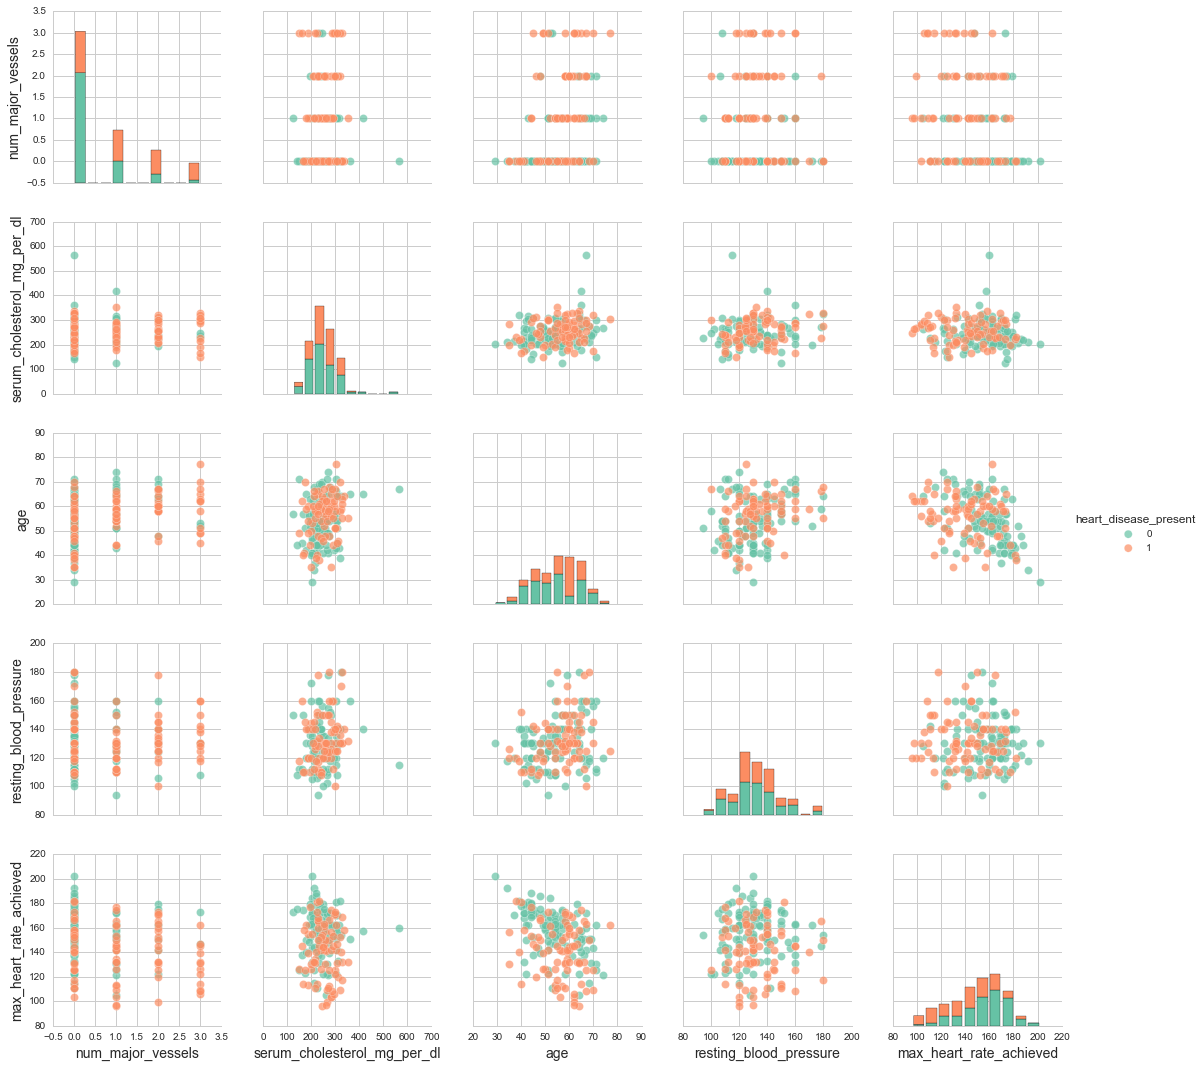

In [64]:
with sns.axes_style("whitegrid"):
    plt.rcParams["axes.labelsize"] = 14
    sns.pairplot(train_df, 
                 vars=['num_major_vessels', 'serum_cholesterol_mg_per_dl', 'age', 
                       'resting_blood_pressure', 'max_heart_rate_achieved'], 
                 hue='heart_disease_present', 
                 palette=cat_palette, 
                 plot_kws={'alpha':0.7, 's':65}, size=3)

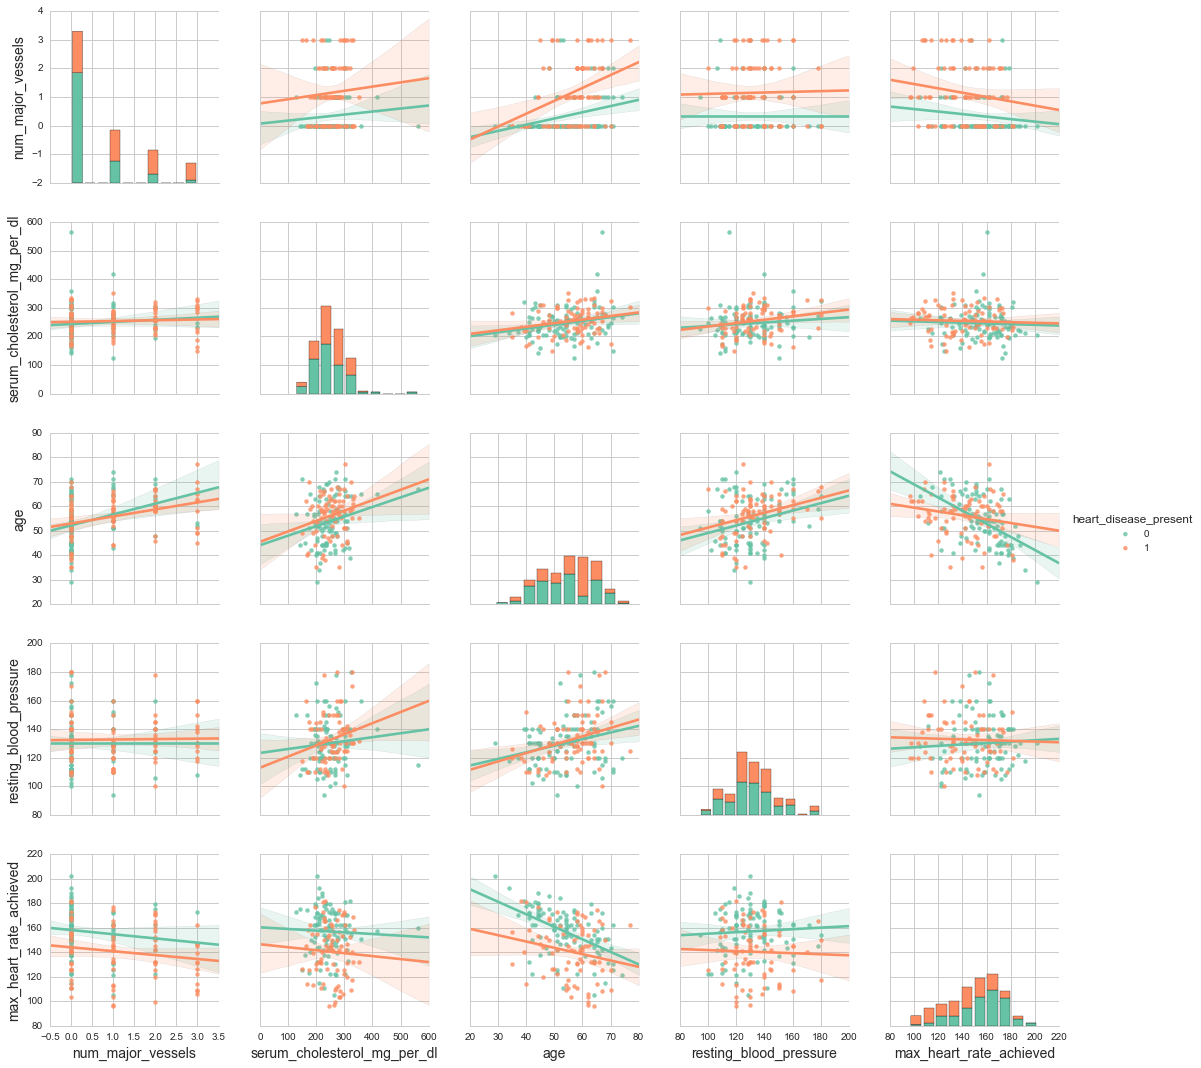

In [97]:
with sns.axes_style("whitegrid"):
    plt.rcParams["axes.labelsize"] = 14
    sns.pairplot(train_df, 
                 vars=['num_major_vessels', 'serum_cholesterol_mg_per_dl', 'age', 
                       'resting_blood_pressure', 'max_heart_rate_achieved'], 
                 kind='reg',
                 diag_kind='hist',
                 hue='heart_disease_present', 
                 palette=cat_palette, 
                 size=3)

From the grid of plots above, 

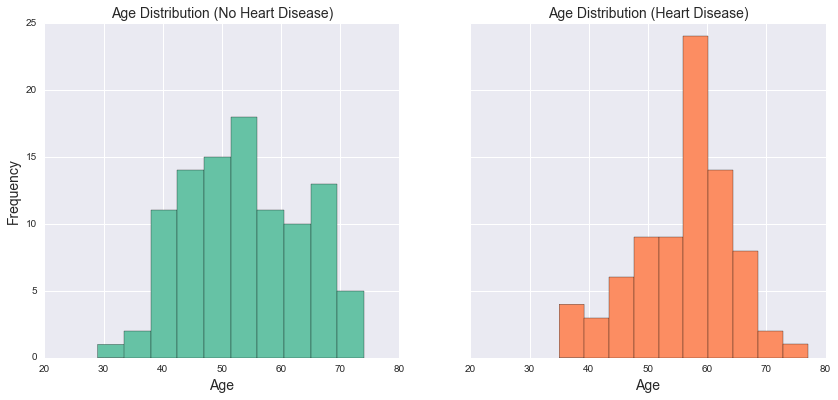

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(14,6))
train_df[train_df['heart_disease_present']==0]['age'].plot(kind='hist', color=colors[0], ax=ax[0])
train_df[train_df['heart_disease_present']==1]['age'].plot(kind='hist', color=colors[1], ax=ax[1])
ax[0].set_xlabel('Age', fontsize=14)
ax[1].set_xlabel('Age', fontsize=14)
ax[0].set_title('Age Distribution (No Heart Disease)', fontsize=14)
ax[1].set_title('Age Distribution (Heart Disease)', fontsize=14)

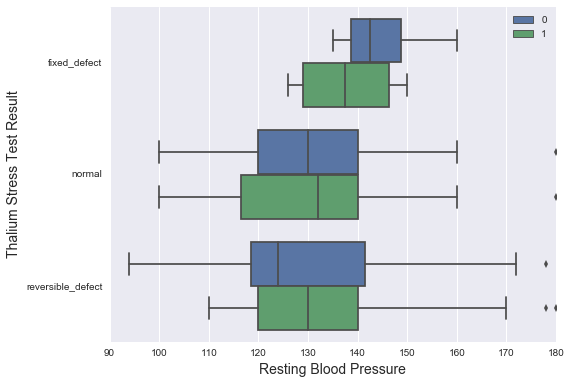

In [46]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=train_df, 
              y='thal', 
              x='resting_blood_pressure', 
              hue='heart_disease_present', 
              ax=ax)
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
ax.legend(loc='best')

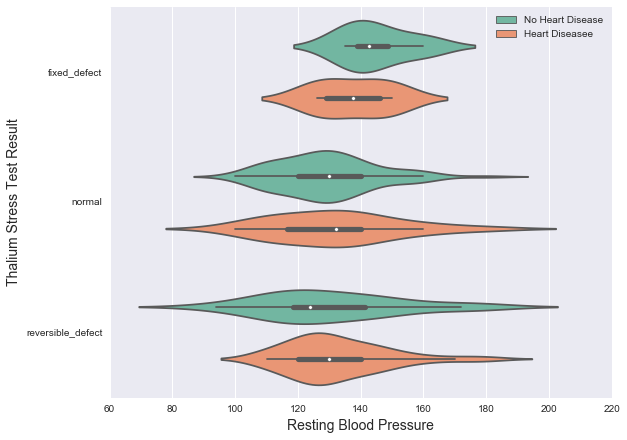

In [94]:
fig, ax = plt.subplots(figsize=(9,7))
sns.violinplot(data=train_df, 
            y='thal', 
            x='resting_blood_pressure', 
            hue='heart_disease_present',
            palette=cat_palette,
            ax=ax)
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best', )
ax.set_title('')

In [ ]:
# Create the same pairgrid but map a histogram on the diag
g = sns.PairGrid(train_df, vars=["fatal_collisions", "premiums"], size=4)
g2 = g.map_diag(plt.hist)
g3 = g2.map_offdiag(plt.scatter)

In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 14 columns):
heart_disease_present                   180 non-null int64
slope_of_peak_exercise_st_segment       180 non-null category
thal                                    180 non-null category
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null category
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null category
resting_ekg_results                     180 non-null category
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null category
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null category
dtypes: category(7), float64(1), int64(6)
m

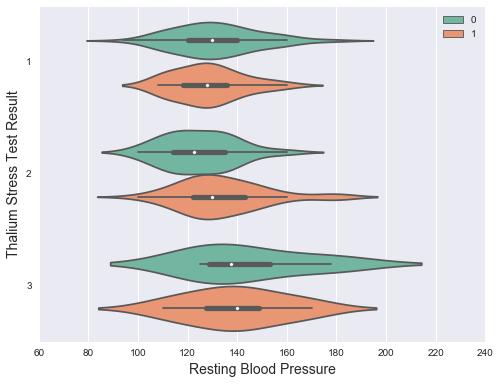

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=train_df, 
            y='slope_of_peak_exercise_st_segment', 
            x='resting_blood_pressure', 
            hue='heart_disease_present',
            palette=cat_palette,
            ax=ax)
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
ax.legend(loc='best')

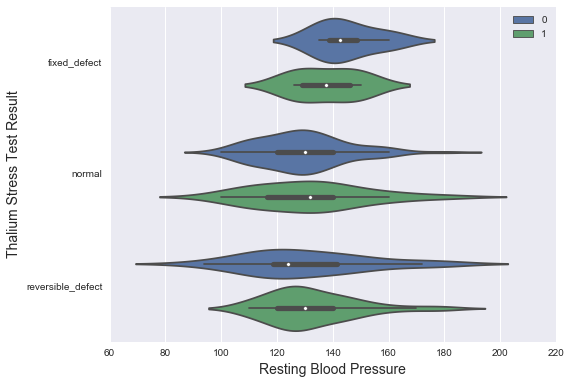

In [158]:
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=train_df, 
            y='thal', 
            x='resting_blood_pressure', 
            hue='heart_disease_present',  
            ax=ax)
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
ax.legend(loc='best')

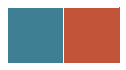

In [30]:
cmap = sns.diverging_palette(220, 20, n=2)
sns.palplot(cmap)

In [145]:
type(cmapy)

seaborn.palettes._ColorPalette

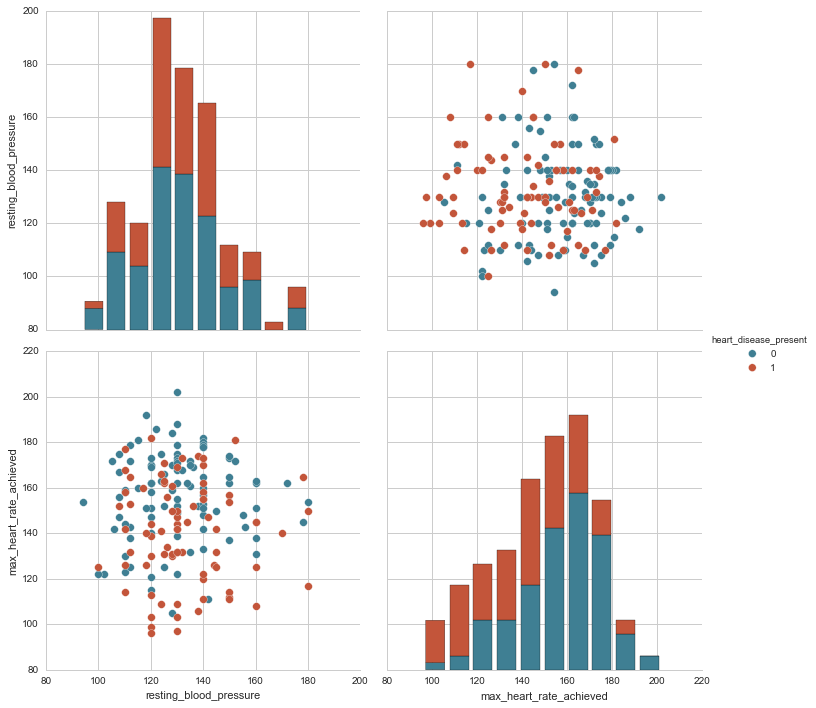

In [159]:
with sns.axes_style("whitegrid"):
    g = sns.pairplot(data=train_df,
                     vars=['resting_blood_pressure', 'max_heart_rate_achieved'],
                     kind='scatter',
                     hue='heart_disease_present',
                     palette=cmap,
                     diag_kws={'alpha':1.0},
                     plot_kws={'s':60},
                     size=5)